# Sorce Solstice Scan Analysis
In this notebook, three scans are analyzed - quickscan, upscan and downscan.  The irradiance for each scan is computed and compared with the reference.

It is found that the scan data produces innacurate results around the 102000 grate position (~181 wavelength(nm)). About twice as much error is introduced on the downscan as the upscan.  In the downscan, the grate position is successively decreased from one measurement to the next.  Likewise, upscan increases the grate position for each successive measurement.  Wavelength is a function of grate position, decreasing as grate position increases.

In [60]:
from math import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('precision', 17)

## Create scan dataframe consisting of instrument telemetry and integration time

In [61]:
def get_intTime(secondsSinceGpsEpoch):
    return integrationTime_pdf[integrationTime_pdf['secondsSinceGpsEpoch'] == \
        secondsSinceGpsEpoch]['intTime (ms)'].values[0]

def create_scan_pdf(scan):
    startTime = plans_pdf[plans_pdf['planName'] == scan]['startTime'].values[0] // 1e6
    endTime = plans_pdf[plans_pdf['planName'] == scan]['endTime'].values[0] // 1e6
    
    scan_pdf = instrumentTelemetry_pdf[(instrumentTelemetry_pdf['secondsSinceGpsEpoch'] >= startTime) \
                             & (instrumentTelemetry_pdf['secondsSinceGpsEpoch'] <= endTime)] \
                             .reset_index(drop=True)
    scan_pdf['intTime (ms)'] = scan_pdf['secondsSinceGpsEpoch'].apply(get_intTime)
    return scan_pdf

## Add irradiance to a scan dataframe, using the following equations.

    Wavelength (the grating equation) :
        offset = 239532.38
        stepSize = 2.4237772022101214E-6 [rad]
        d = 277.77777777777777 [nm]
        phiGInRads = 0.08503244115716374 [rad]
        ang1 = (offset - gratingPosition) * stepSize
        wavelength = 2 * d * sin(ang1) * cos(phiGInRads / 2.0) [nm]

    counts/second/area :
        integrationTime -> convert to seconds from ms
        cr = counts / integrationTime [counts / sec / nm] (the per nm is from the sampling at the specific grating position)
        apArea = .01 [cm^2] (aperature area)
        photonsPerSecondPerCm2 = cr / apArea [photons/sec/cm^2/nm]

    watts/meter^2 :
        wavelengthInMeters -> convert to meters from nm
        h = 6.62606957E-34 [J*s]
        c = 299792458.0 [m/s]
        energyPerPhoton = h * c / wavelengthInMeters [J]
        wattsPerM2 = photonsPerSecondPerArea * 1e2 * 1e2 * energyPerPhoton [watts/m^2/nm]


In [62]:
def add_irradiance(scan_pdf):
    offset = 239532.38
    stepSize = 2.4237772022101214E-6
    d = 277.77777777777777
    phiGInRads = 0.08503244115716374
    
    ang1 = (offset - scan_pdf['gratPos']) * stepSize
    wavelength = 2 * d * ang1.apply(np.sin) * cos(phiGInRads / 2.0)
      
    intTimeInSeconds = scan_pdf['intTime (ms)'] * 1e-3
    cr = scan_pdf['counts'] / intTimeInSeconds
    apArea = .01
    photonsPerSecondPerCm2 = cr / apArea
    
    wavelengthInMeters = wavelength * 1e-9
    h = 6.62606957E-34
    c = 299792458.0
    energyPerPhoton = h * c / wavelengthInMeters
    wattsPerM2 = photonsPerSecondPerCm2 * 1e2 * 1e2 * energyPerPhoton
    
    scan_pdf['wattsPerM2'] = wattsPerM2
    scan_pdf['wavelength(nm)'] = wavelength
    # truncate to nearest .005, then round to 3 digits to right of decimal point
    scan_pdf['wavelengthRounded(nm)'] = wavelength.apply(lambda x: round((x // .005) * .005, 3))
    
    return scan_pdf

## Calculate irradiance error

In [63]:
def get_irradiance_error(wavelength, irradiance):
    reference_irradiance = referenceSpectrum_pdf[referenceSpectrum_pdf['wavelength(nm)'] == \
                                 wavelength]['irradiance (watts/m^2)'].values[0]
    return (irradiance - reference_irradiance)/reference_irradiance

## Load data files

All files are comma separated with a one line header.

  * **detectorTemp.txt** : in degrees Celsius. It is roughly sampled at 1 second.
  * **distanceAndDoppler.txt** : These are the corrections used to adjust for the changing
    distance and velocity of the spacecraft relative to the sun.
  * **instrumentTelemetry.txt** : Includes grating position and measured detector counts. It is sampled
    proportional to the current integration time. (keep in mind that this is measured counts which
    which could be dependent on other variables)
  * **integrationTime.txt** : This is the current set integration time (ms) of the instrument.
    Assume the value is constant until there is a new value.
  * **plans.txt** : This file includes the experiment names with start/end times. You can find the
    time ranges of the plans of interest her. [start, end)
  * **referenceSpectrum.txt** : This is a reference spectrum with accurate wavelengths. The current
    irradiance measurements will be within 15% of this spectrum.

Add *secondsSinceGpsEpoch* columns to **instrumentTelemetry** and **integrationTime**, so that entries from these two data sets can be matched.

In [64]:
detectorTemp_pdf = pd.read_csv('laspCodingTestDataFiles/detectorTemp.txt', skipinitialspace=True) 
#display(detectorTemp_pdf.head()) 
#print('\033[1mdetectorTemp\033[0m', detectorTemp_pdf.shape)

distanceAndDoppler_pdf = pd.read_csv('laspCodingTestDataFiles/distanceAndDoppler.txt', skipinitialspace=True) 
#display(distanceAndDoppler_pdf.head()) 
#print('\033[1mdistanceAndDoppler\033[0m', distanceAndDoppler_pdf.shape)

instrumentTelemetry_pdf = pd.read_csv('laspCodingTestDataFiles/instrumentTelemetry.txt', skipinitialspace=True) 
instrumentTelemetry_pdf['secondsSinceGpsEpoch'] = instrumentTelemetry_pdf['microsecondsSinceGpsEpoch'] // 1e6 
#display(instrumentTelemetry_pdf.head()) 
#display(instrumentTelemetry_pdf.describe())
#print('\033[1minstrumentTelemetry\033[0m', instrumentTelemetry_pdf.shape)

integrationTime_pdf = pd.read_csv('laspCodingTestDataFiles/integrationTime.txt', skipinitialspace=True) 
integrationTime_pdf['secondsSinceGpsEpoch'] = integrationTime_pdf['microsecondsSinceGpsEpoch'] // 1e6 
#display(integrationTime_pdf.head()) 
#display(integrationTime_pdf.describe())
#print('\033[1mintegrationTime\033[0m', integrationTime_pdf.shape)

plans_pdf = pd.read_csv('laspCodingTestDataFiles/plans.txt', encoding='latin-1', skipinitialspace=True) 
#display(plans_pdf.head()) 
#print('\033[1mplans\033[0m', plans_pdf.shape)

referenceSpectrum_pdf = pd.read_csv('laspCodingTestDataFiles/referenceSpectrum.txt', skipinitialspace=True) 
#display(referenceSpectrum_pdf.head())
#display(referenceSpectrum_pdf.describe())
#print('\033[1mreferenceSpectrum\033[0m', referenceSpectrum_pdf.shape)

## Graph grate position distribution using kernel density plot

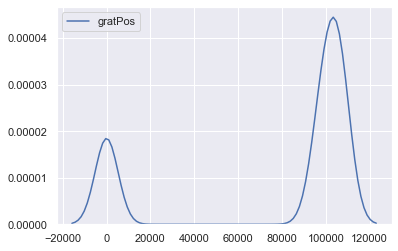

In [65]:
sns.set(font_scale=1)
ax = sns.kdeplot(instrumentTelemetry_pdf['gratPos'])

## Graph detector temperature over time

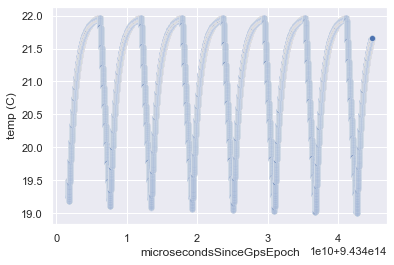

In [66]:
sns.set(font_scale=1)
ax = sns.scatterplot(x='microsecondsSinceGpsEpoch', y='temp (C)', data=detectorTemp_pdf, alpha=.25)

## Calculate irradiance and error for each scan

### QuickScan

In [67]:
QuickScan_pdf = create_scan_pdf('QuickScan')
#display(QuickScan_pdf.head())

QuickScan_pdf = add_irradiance(QuickScan_pdf)
#display(QuickScan_pdf.head())
#display(QuickScan_pdf.describe())

# Drop outlier wavelength entries, n.b. grate position of 0, yields wavelength of 304.5
QuickScan_pdf = QuickScan_pdf[(QuickScan_pdf['wavelength(nm)'] >= 172) & (QuickScan_pdf['wavelength(nm)'] <= 193)]

QuickScan_pdf['error'] = \
    QuickScan_pdf.apply(lambda x: get_irradiance_error(x['wavelengthRounded(nm)'], x['wattsPerM2']), axis=1)
#display(QuickScan_pdf.head()) 
#display(QuickScan_pdf.describe())

### DownScan

In [68]:
DownScan_pdf = create_scan_pdf('DownScan')
#display(DownScan_pdf.head())

DownScan_pdf = add_irradiance(DownScan_pdf)
#display(DownScan_pdf.head())
#display(DownScan_pdf.describe())

# Drop outlier wavelength entries
DownScan_pdf = DownScan_pdf[(DownScan_pdf['wavelength(nm)'] >= 172) & (DownScan_pdf['wavelength(nm)'] <= 193)]

DownScan_pdf['error'] = \
    DownScan_pdf.apply(lambda x: get_irradiance_error(x['wavelengthRounded(nm)'], x['wattsPerM2']), axis=1)
#display(DownScan_pdf.head()) #3display(DownScan_pdf.describe())

 ### UpScan

In [69]:
UpScan_pdf = create_scan_pdf('UpScan')
#display(DownScan_pdf.head())

UpScan_pdf = add_irradiance(UpScan_pdf)
#display(UpScan_pdf.head())
#display(UpScan_pdf.describe())

UpScan_pdf['error'] = \
    UpScan_pdf.apply(lambda x: get_irradiance_error(x['wavelengthRounded(nm)'], x['wattsPerM2']), axis=1)
#display(UpScan_pdf.head()) 
#display(UpScan_pdf.describe())

## Combine scan dataframes, to use seaborn facet grid

In [70]:
QuickScan_pdf['scanType'] = 'QuickScan'
DownScan_pdf['scanType'] = 'DownScan'
UpScan_pdf['scanType'] = 'UpScan'

AllScans_pdf = pd.concat([QuickScan_pdf, DownScan_pdf, UpScan_pdf], ignore_index=True)
#display(AllScans_pdf.head())

## Compare scans by wavelength & grate position over time

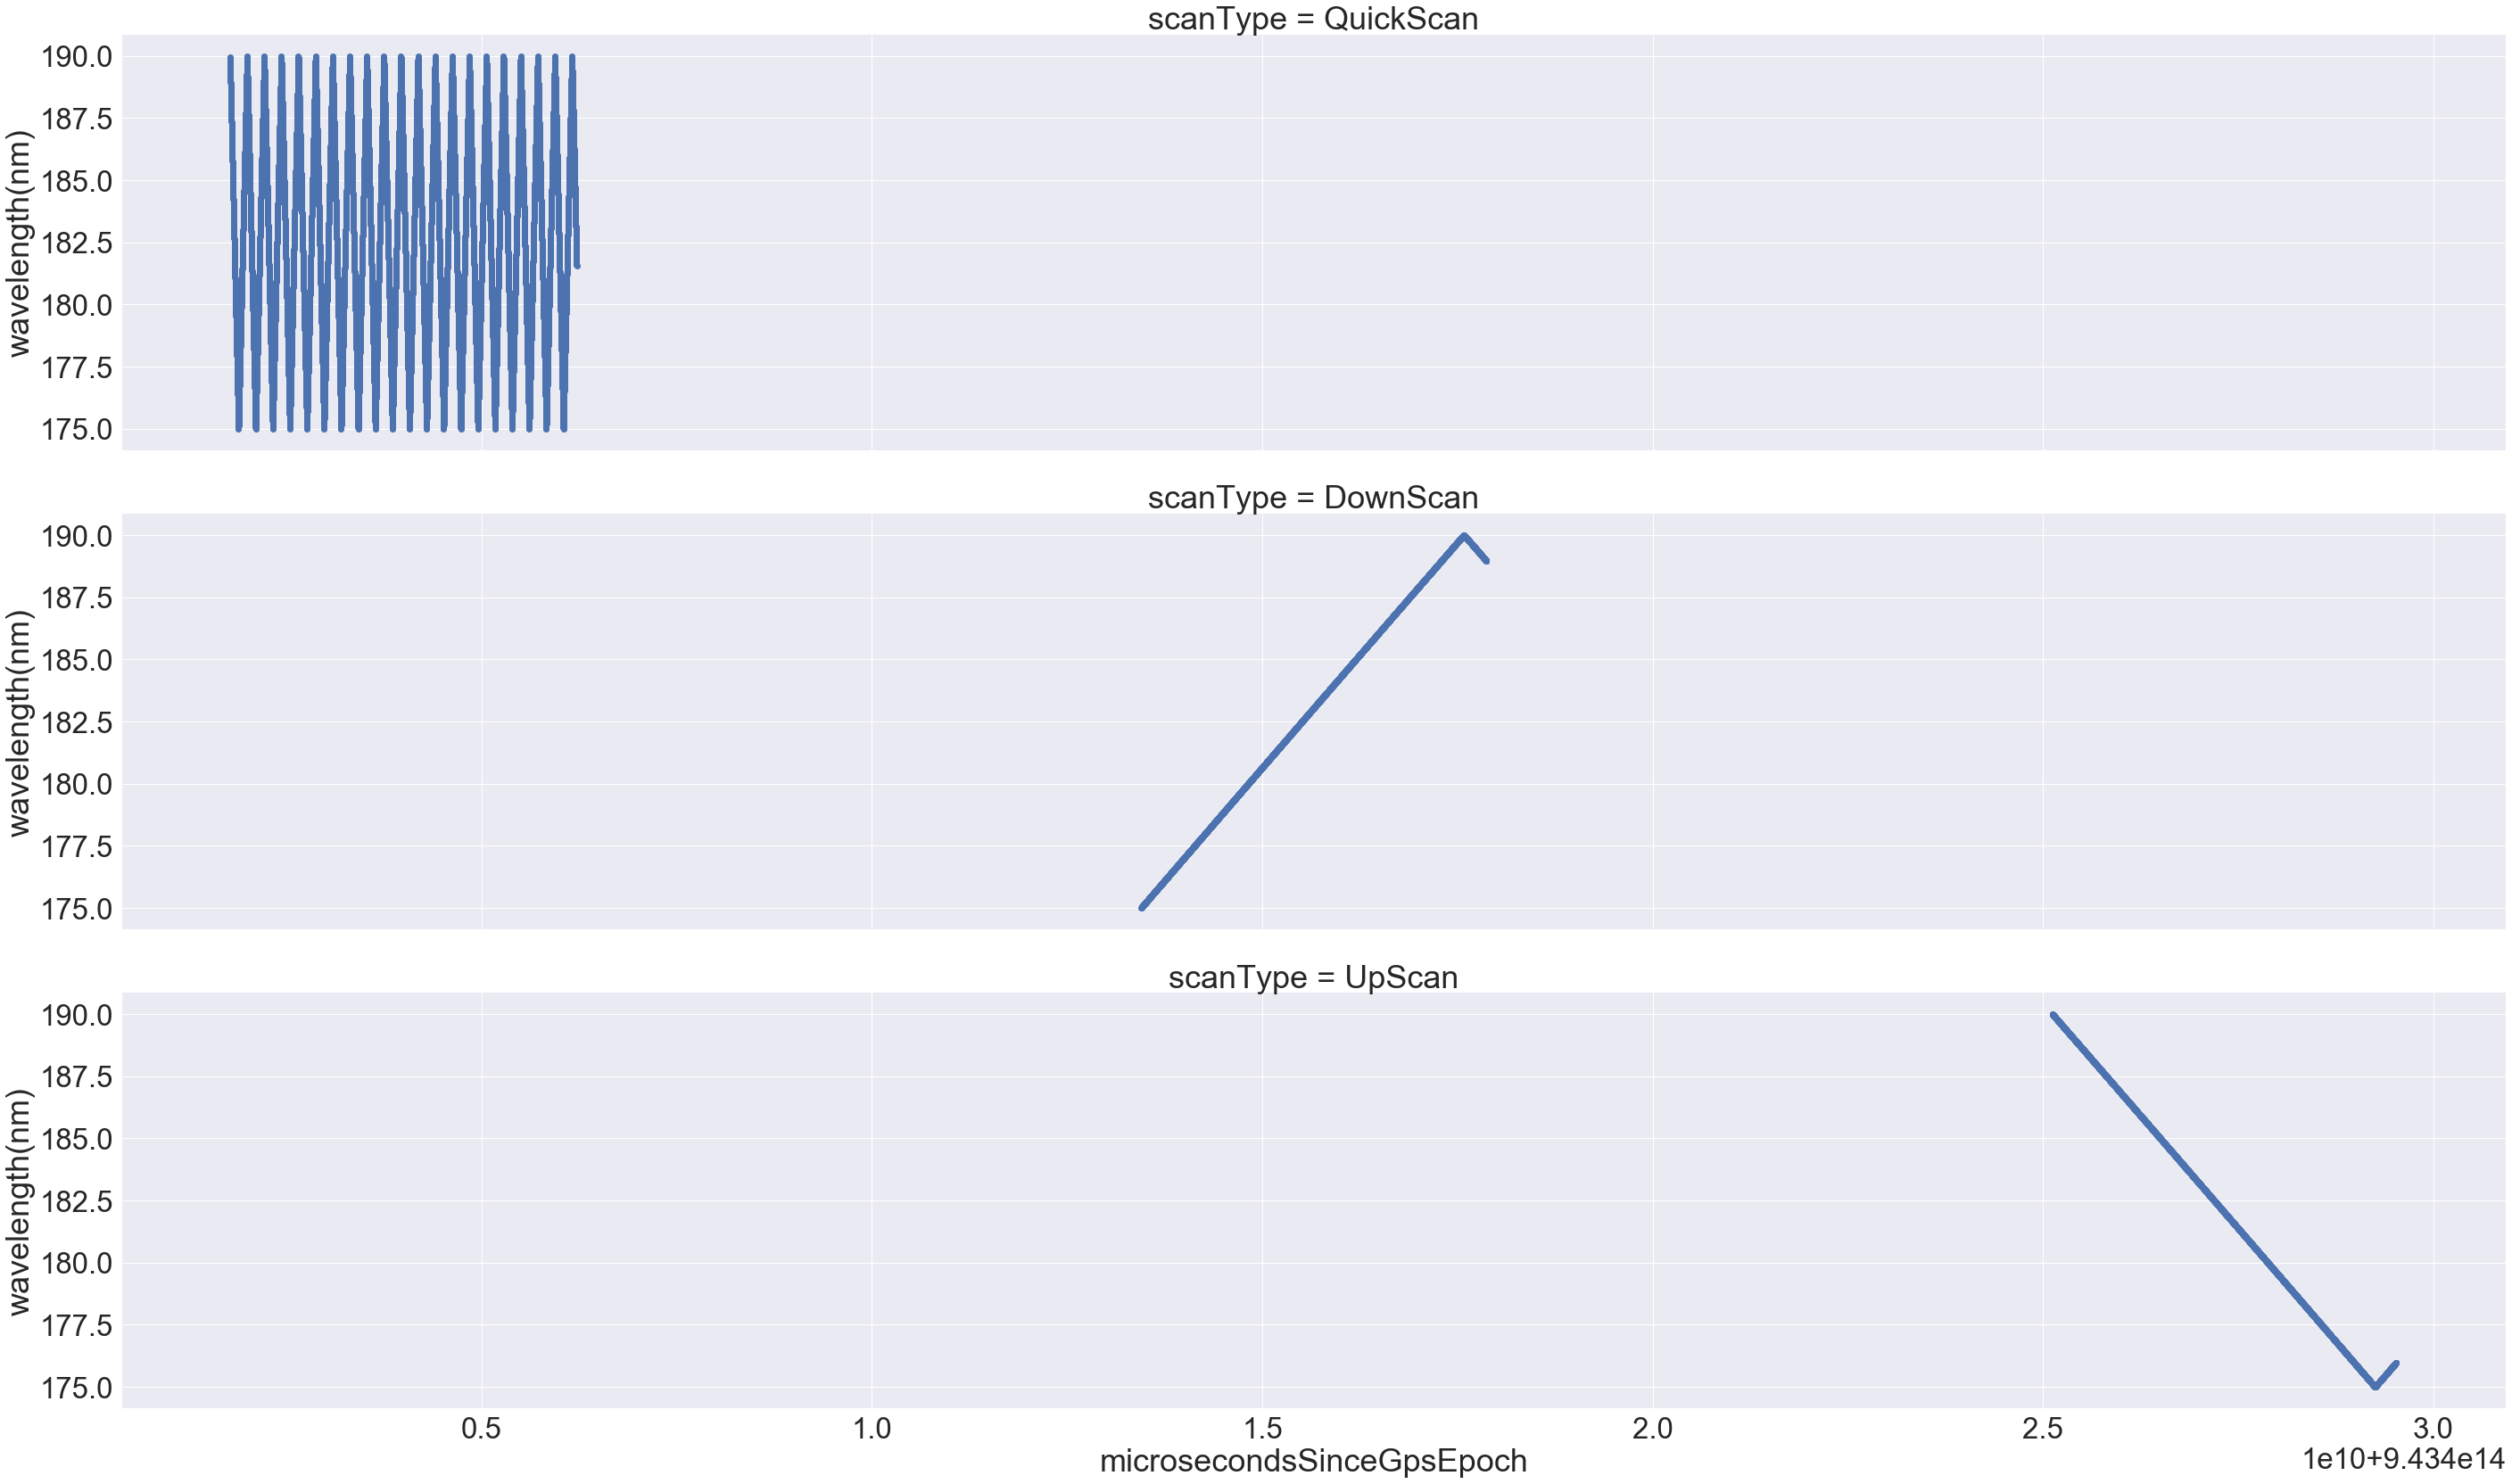

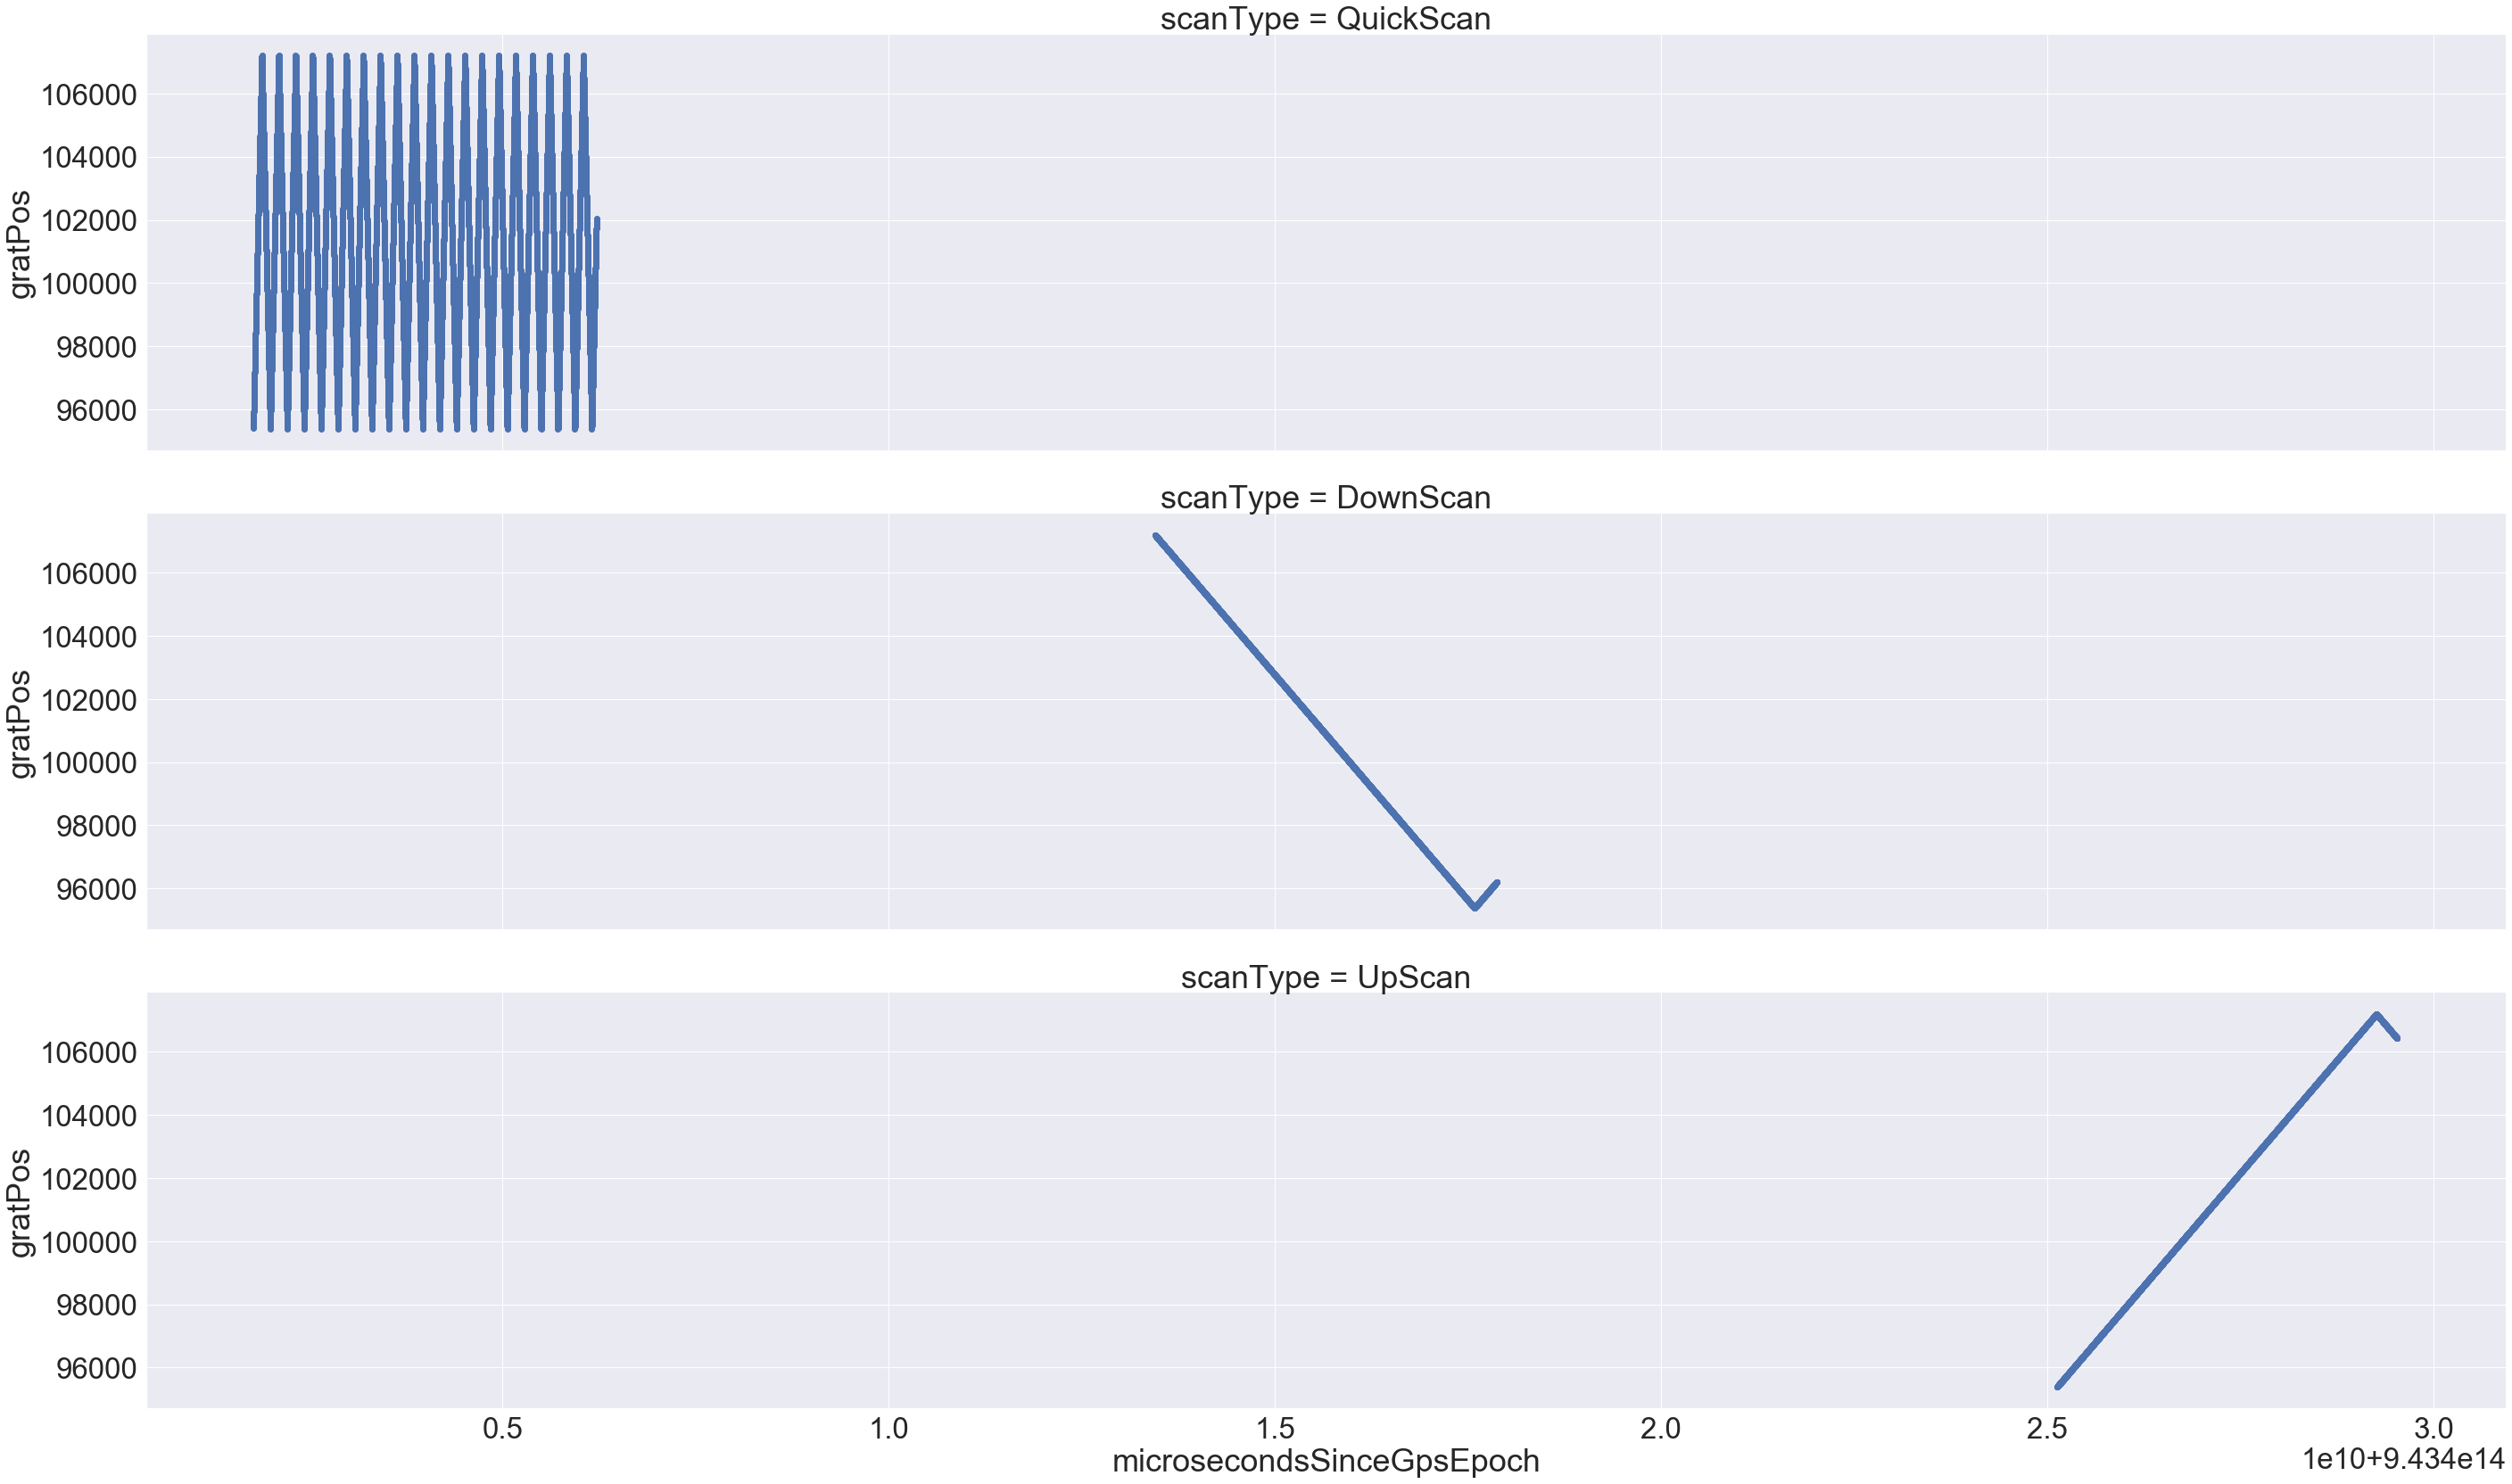

In [71]:
sns.set(font_scale=3)
g = sns.FacetGrid(AllScans_pdf, row='scanType', height=8, aspect=5)
g = g.map(plt.scatter, 'microsecondsSinceGpsEpoch', 'wavelength(nm)')

g = sns.FacetGrid(AllScans_pdf, row='scanType', height=8, aspect=5)
g = g.map(plt.scatter, 'microsecondsSinceGpsEpoch', 'gratPos')

## Plot irradiance and error as a function of wavelength and grate position
The charts below show an anomaly in the relationship between irradiance and grate position / wavelength around the 102000 grate position (~ 181 wavelength(nm)).  In that area, there is a spike of differences (errors) from the reference irradiance.  The range of differences is about twice as great on the downscan as the upscan. The range of differences is skewed towards the positive side.

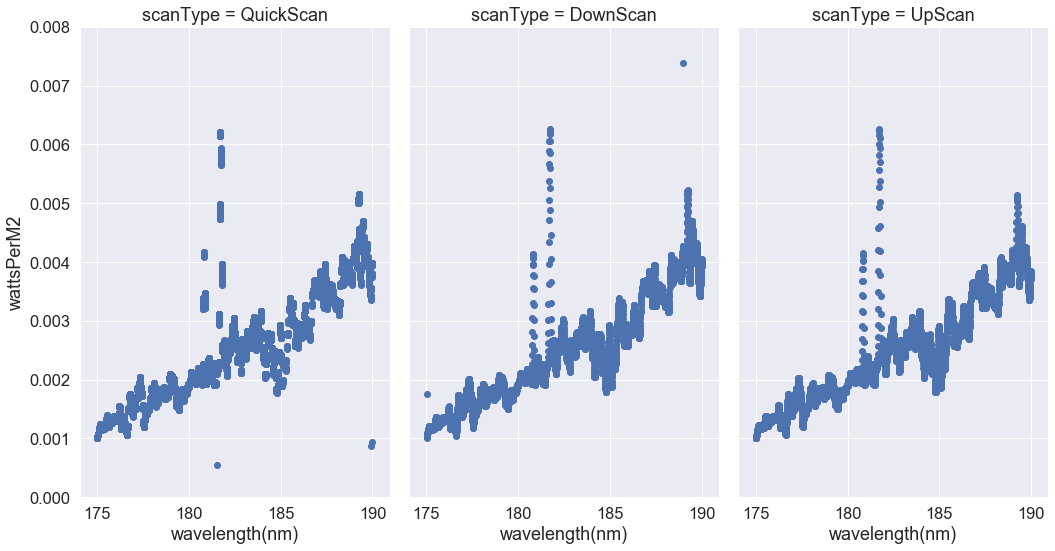

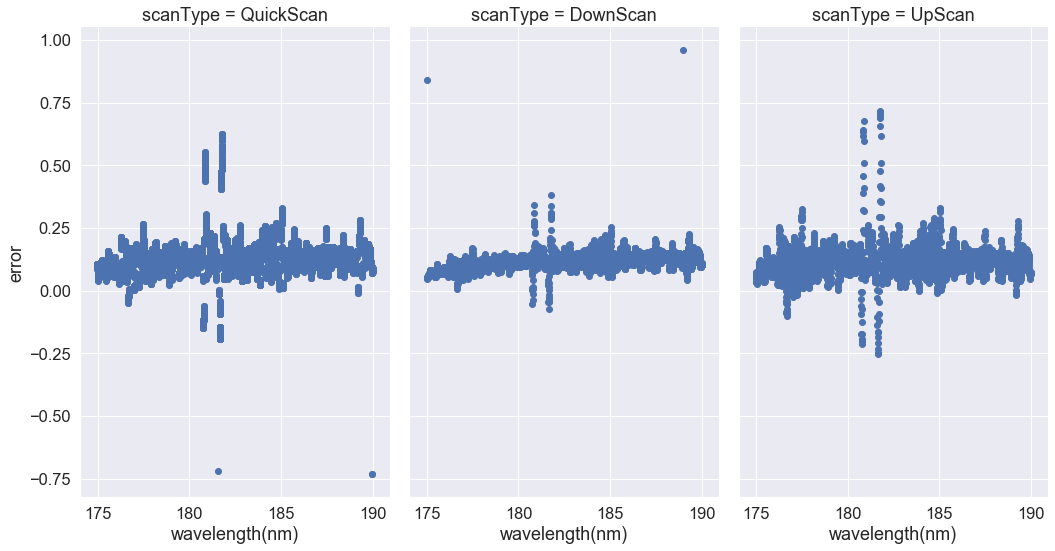

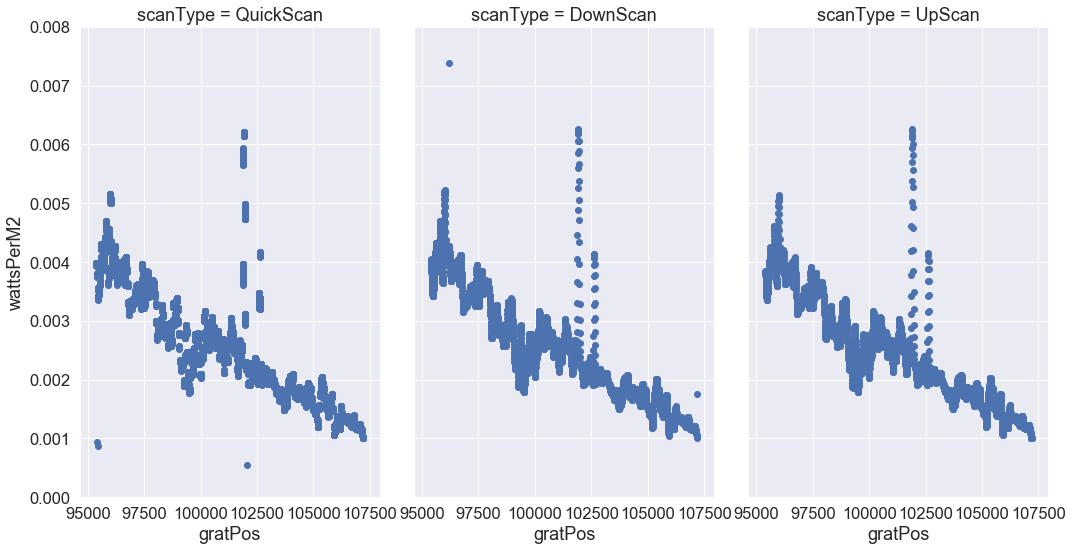

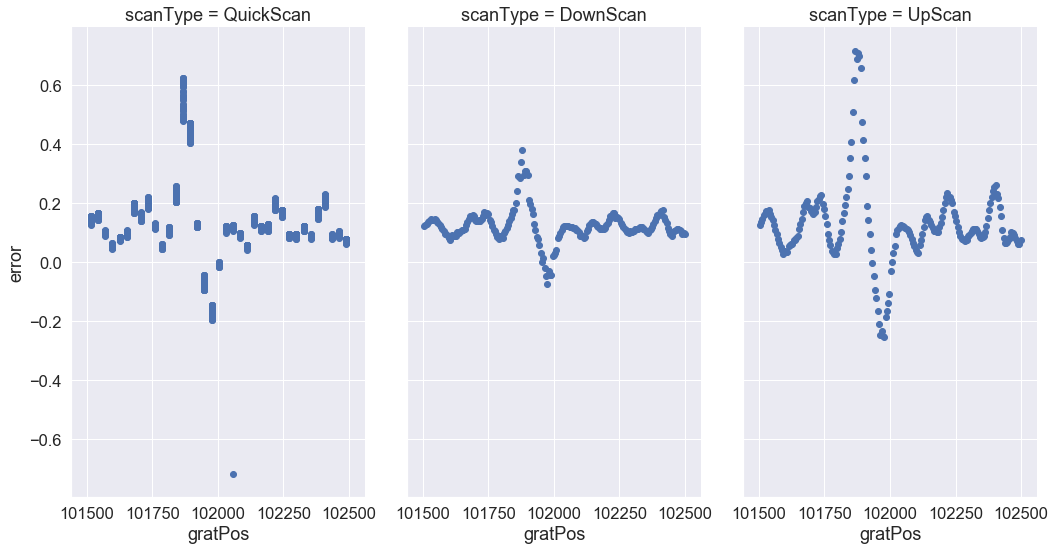

In [72]:
sns.set(font_scale=1.5)
g = sns.FacetGrid(AllScans_pdf, col='scanType', height=8, aspect=5/8)
plt.ylim(0, .008)
g = g.map(plt.scatter, 'wavelength(nm)', 'wattsPerM2')

g = sns.FacetGrid(AllScans_pdf, col='scanType', height=8, aspect=5/8)
g = g.map(plt.scatter, 'wavelength(nm)', 'error')

g = sns.FacetGrid(AllScans_pdf, col='scanType', height=8, aspect=5/8)
plt.ylim(0, .008)
g = g.map(plt.scatter, 'gratPos', 'wattsPerM2')

g = sns.FacetGrid(AllScans_pdf[(AllScans_pdf['gratPos'] >= 101500) & (AllScans_pdf['gratPos'] <= 102500)],
                  col='scanType', 
                  height=8, 
                  aspect=5/8)
g = g.map(plt.scatter, 'gratPos', 'error')

## Plot irradiance and error for all scans on single scatter plot

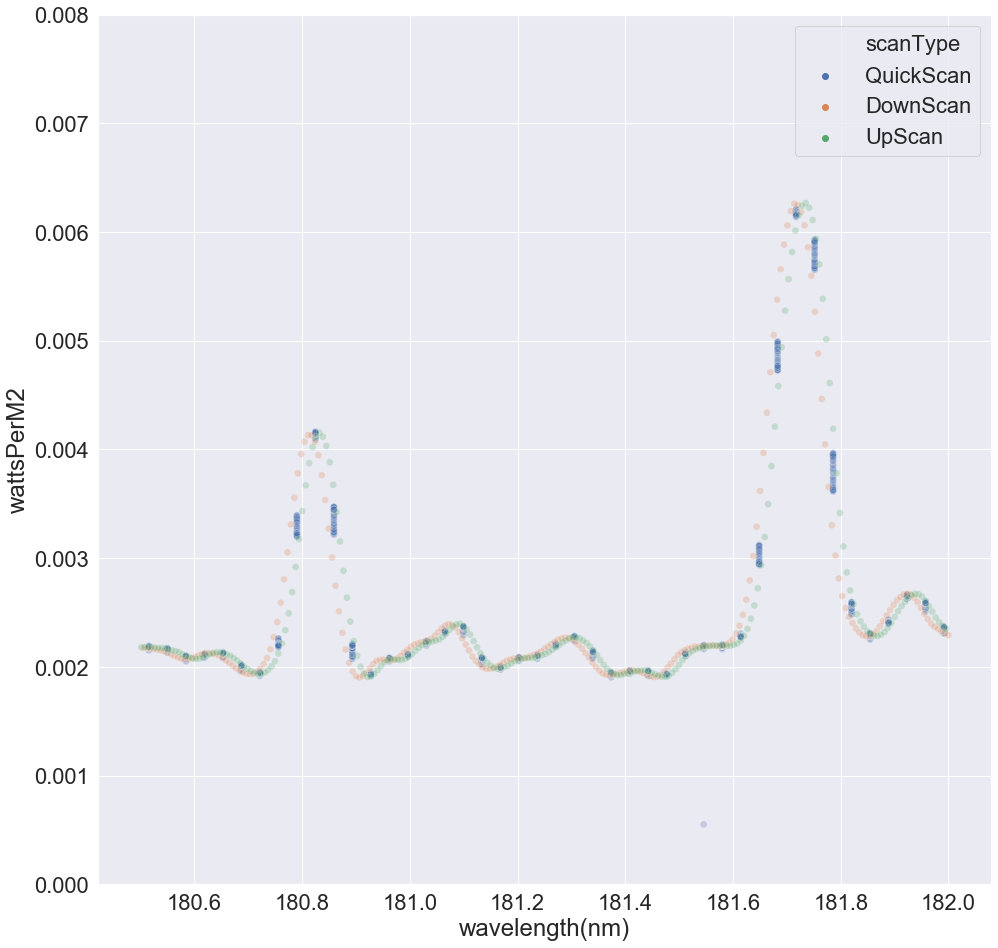

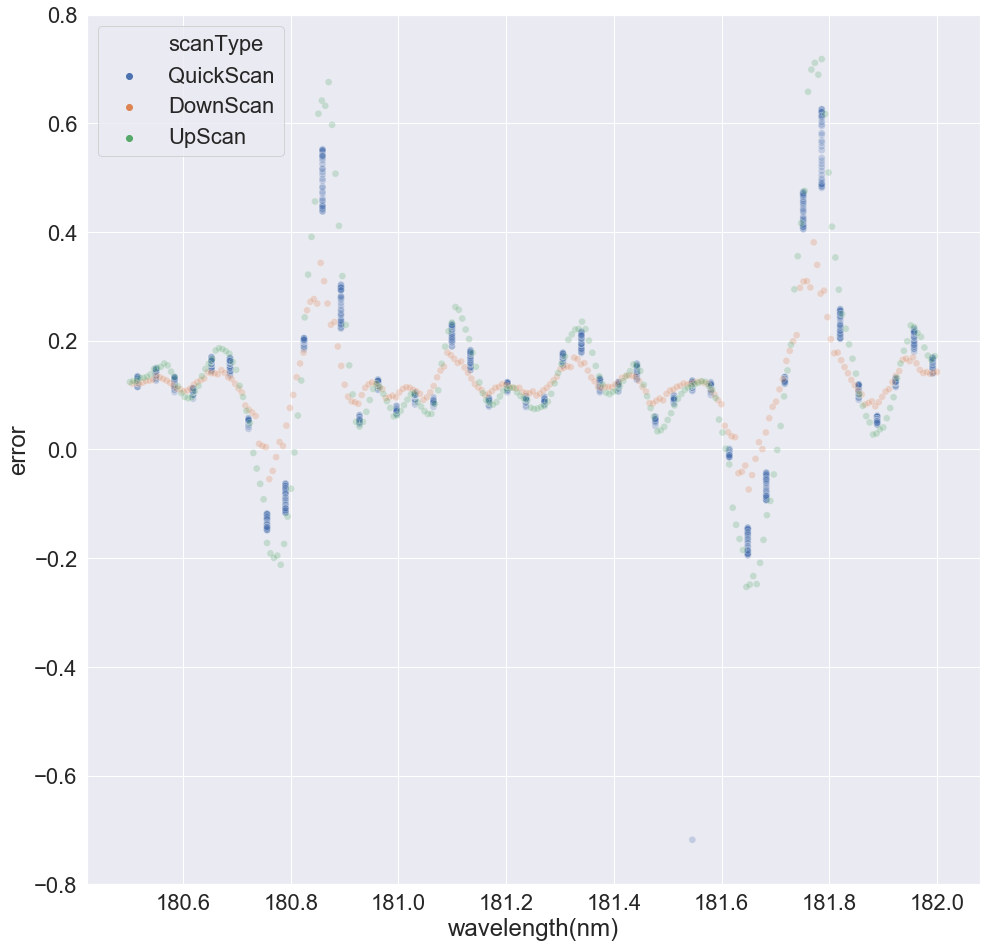

In [73]:
# Filter All Scans data frame to contain entries between 180.5 & 182
AllScans180_pdf = AllScans_pdf[(AllScans_pdf['wavelength(nm)'] >= 180.5) & \
                                      (AllScans_pdf['wavelength(nm)'] <= 182)]


sns.set(font_scale=2)
plt.figure(figsize=(16,16))
plt.ylim(0, .008)
ax = sns.scatterplot(x='wavelength(nm)', 
                     y='wattsPerM2', 
                     hue='scanType', 
                     alpha=.25,
                     s=50,
                     data=AllScans180_pdf)

plt.figure(figsize=(16,16))
plt.ylim(-0.8, 0.8)
ax = sns.scatterplot(x='wavelength(nm)', 
                     y='error', 
                     hue='scanType', 
                     alpha=.25,
                     s=50,
                     data=AllScans180_pdf)